In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import random

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# Remove dodgy images and load data

In [2]:
path=r'C:\Users\berid\python\chest x ray\chest_xray\chest_xray\train'
categories=['NORMAL','PNEUMONIA']

In [ ]:
data=[]
labels=[]

for category in categories:
    label=categories.index(category)
    for i,file in enumerate(os.listdir(os.path.join(path,category))):
        img_path=os.path.join(path,category,file)
        img=cv2.imread(img_path)
        if img is not None:
            img=cv2.resize(img,(256,256))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            data.append(img)
            labels.append(label)
        
        print(i,end='\r')


In [ ]:
data=np.array(data)
labels=np.array(labels)

In [ ]:
data=data/255

In [ ]:
combined = list(zip(data, labels))
np.random.shuffle(combined)
shuffled_data, shuffled_labels = zip(*combined)

data = np.array(shuffled_data)
labels = np.array(shuffled_labels)


In [ ]:
pickle.dump(data,open(os.path.join(path,'data.pickle'),'wb'))
pickle.dump(labels,open(os.path.join(path,'labels.pickle'),'wb'))

In [3]:
data=pickle.load(open(os.path.join(path,'data.pickle'),'rb'))
labels=pickle.load(open(os.path.join(path,'labels.pickle'),'rb'))

In [4]:
data.shape, labels.shape

((5216, 256, 256, 3), (5216,))

<Axes: ylabel='count'>

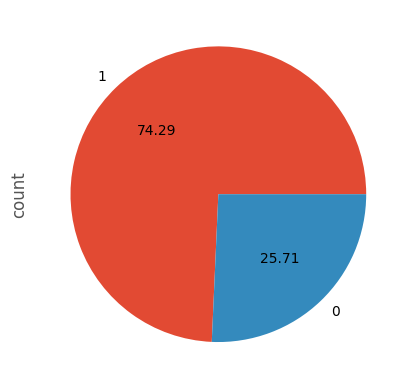

In [5]:
import pandas 
pandas.Series(list(labels)).value_counts().plot.pie(autopct='%.2f')

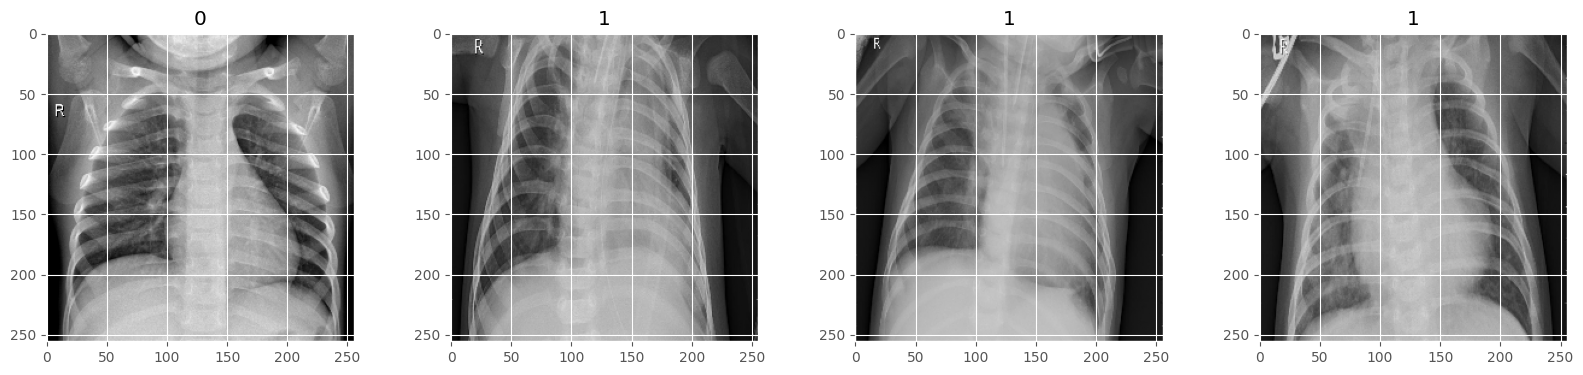

In [6]:
import random

fig,axes=plt.subplots(1,4,figsize=(20,4))
for i,index in enumerate(random.sample(range(len(data)),4)):
    axes[i].imshow(data[index])
    axes[i].set_title(labels[index])

# Splitting

In [7]:
train_index=int(len(data)*0.7)
val_index=int(len(data)*0.9)

train_data, train_labels=data[:train_index], labels[:train_index]
val_data, val_labels=data[train_index:val_index], labels[train_index:val_index]
test_data, test_labels=data[val_index:], labels[val_index:]

In [8]:
train_data.shape,val_data.shape,test_data.shape

((3651, 256, 256, 3), (1043, 256, 256, 3), (522, 256, 256, 3))

# Building CNN Model

In [9]:
from keras.models import Sequential
from keras.layers import Input, Conv2D,MaxPooling2D,Flatten,Dense

In [10]:
model=Sequential()

model.add(Conv2D(16,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
logdir=r'C:\Users\berid\python\chest x ray\model\logs'

In [13]:
tensorboard_callbakcs=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
hist=model.fit(train_data,train_labels,epochs=25,validation_data=(val_data,val_labels),callbacks=[tensorboard_callbakcs])

Epoch 1/25
115/115 [==============================] - 35s 284ms/step - loss: 0.2941 - accuracy: 0.8685 - val_loss: 0.0879 - val_accuracy: 0.9732
Epoch 2/25
115/115 [==============================] - 28s 240ms/step - loss: 0.1137 - accuracy: 0.9575 - val_loss: 0.1068 - val_accuracy: 0.9645
Epoch 3/25
115/115 [==============================] - 27s 235ms/step - loss: 0.0871 - accuracy: 0.9688 - val_loss: 0.0813 - val_accuracy: 0.9703
Epoch 4/25
115/115 [==============================] - 27s 237ms/step - loss: 0.0669 - accuracy: 0.9745 - val_loss: 0.0770 - val_accuracy: 0.9760
Epoch 5/25
115/115 [==============================] - 28s 240ms/step - loss: 0.0559 - accuracy: 0.9789 - val_loss: 0.4357 - val_accuracy: 0.8629
Epoch 6/25
115/115 [==============================] - 27s 235ms/step - loss: 0.0955 - accuracy: 0.9649 - val_loss: 0.1275 - val_accuracy: 0.9540
Epoch 7/25
115/115 [==============================] - 27s 233ms/step - loss: 0.0683 - accuracy: 0.9729 - val_loss: 0.0793 - val_ac

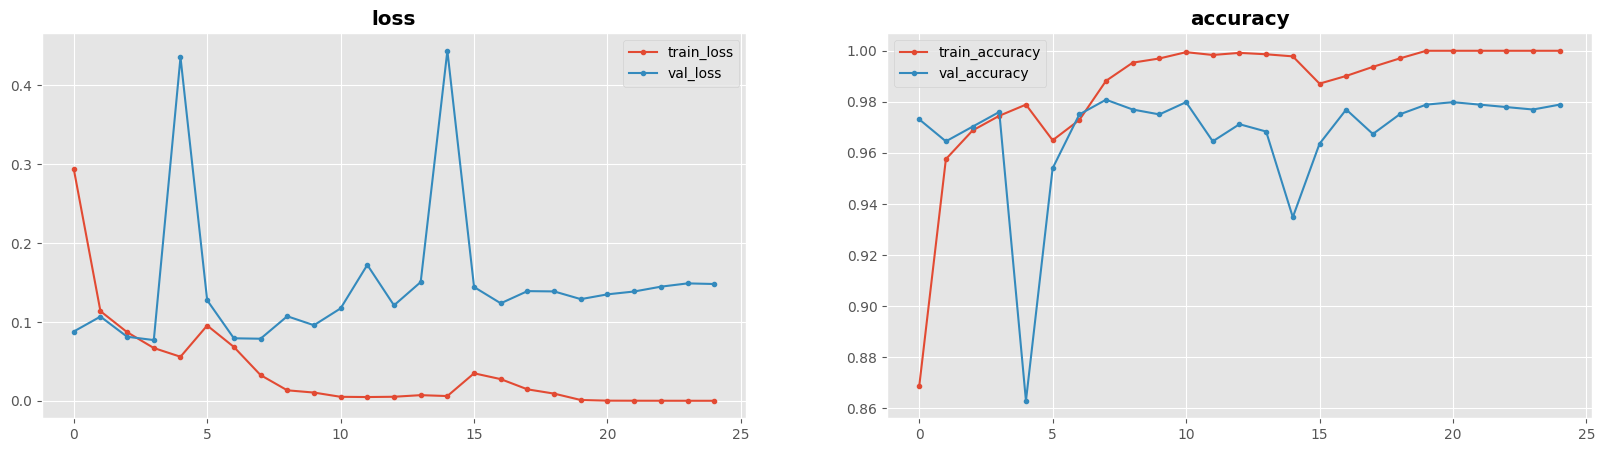

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))

ax1.plot(hist.history['loss'],label='train_loss',marker='.')
ax1.plot(hist.history['val_loss'],label='val_loss',marker='.')
ax1.set_title('loss',fontweight='bold')
ax1.legend()

ax2.plot(hist.history['accuracy'],label='train_accuracy',marker='.')
ax2.plot(hist.history['val_accuracy'],label='val_accuracy',marker='.')
ax2.set_title('accuracy',fontweight='bold')
ax2.legend()

plt.show()

In [16]:
model.save(os.path.join(r'C:\Users\berid\python\chest x ray\model','model.h5'))

In [17]:
from tensorflow.keras.models import load_model

loaded_model=load_model(os.path.join(r'C:\Users\berid\python\chest x ray\model','model.h5'))

In [18]:
loaded_model.evaluate(test_data,test_labels)

17/17 [==============================] - 1s 60ms/step - loss: 0.1337 - accuracy: 0.9732


[0.1336844265460968, 0.9731800556182861]

In [19]:
prediction=loaded_model.predict(test_data)
prediction=(prediction>0.5).astype(int).reshape(len(test_data))

17/17 [==============================] - 1s 66ms/step


In [20]:
from sklearn import metrics

metrics.accuracy_score(prediction,test_labels)

0.9731800766283525

<Axes: >

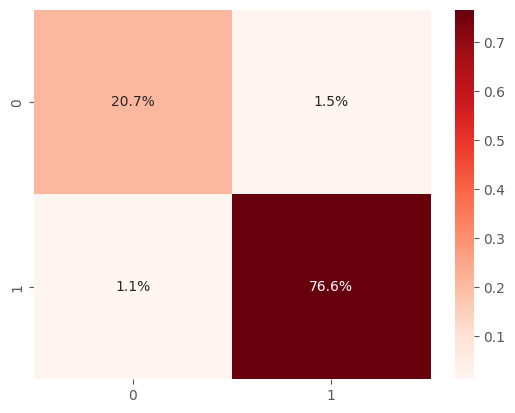

In [21]:
cm=metrics.confusion_matrix(prediction,test_labels)
cm=cm/cm.sum()

sns.heatmap(cm,annot=True,fmt='.1%',cmap='Reds')